# ReAct 框架

- ReAct（Reasoning + Acting）：推理 + 行动，让 Agent 像人一样思考问题、指定策略、执行行动、验证结果
- 将**直接回答问题**转变为**自然语言思考过程**
- 典型 ReAct 步骤：
  - 思考（Reasoning）：分析问题，判断现有信息是否足够，明确下一步策略（是否需要调用外部工具）
  - 行动（Action）：执行思考阶段指定的策略
  - 观察（Observation）：观察执行结果，并记录结果
  - 如此循环

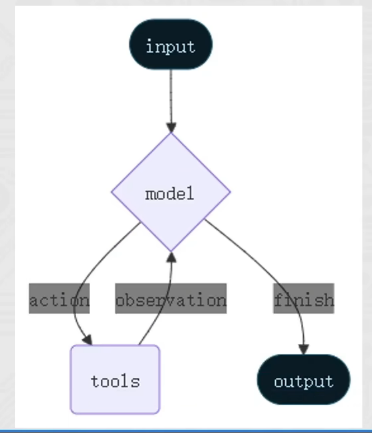

In [1]:
from langchain.agents import create_agent
from langchain_community.chat_models.tongyi import ChatTongyi
from langchain_core.tools import tool

In [3]:
@tool(description="获取体重，返回值是整数，单位千克")
def get_weight() -> int:
    return 65


@tool(description="获取身高，返回值是整数，单位厘米")
def get_height() -> int:
    return 172

In [4]:
agent = create_agent(
    model=ChatTongyi(model="qwen3-max"),
    tools=[get_weight, get_height],
    system_prompt="""你是严格遵循ReAct框架的智能体，必须按「思考→行动→观察→再思考」的流程解决问题，
    且**每轮仅能思考并调用1个工具**，禁止单次调用多个工具。
    并告知我你的思考过程，工具的调用原因，按思考、行动、观察三个结构告知我""",
)

In [5]:
for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "计算我的BMI"}]},
    stream_mode="values"
):
    latest_message = chunk['messages'][-1]

    if latest_message.content:
        print(type(latest_message).__name__, latest_message.content)

    try:
        if latest_message.tool_calls:
            print(f"工具调用： { [tc['name'] for tc in latest_message.tool_calls]  }")
    except AttributeError as e:
        pass

HumanMessage 计算我的BMI
AIMessage ### 思考
要计算BMI（身体质量指数），我需要知道用户的体重（千克）和身高（厘米）。公式为：  
**BMI = 体重（kg） / (身高（m）)^2**  

由于目前缺少这两个数据，我需要先获取其中一个。按照ReAct框架，每轮只能调用一个工具，因此我先获取体重。

### 行动

工具调用： ['get_weight']
ToolMessage 65
AIMessage ### 观察
获取到的体重是65千克。

### 思考
现在我已经有了体重（65kg），接下来需要获取身高（厘米）才能计算BMI。按照ReAct框架，每轮只能调用一个工具，因此下一步我将调用获取身高的工具。

### 行动


工具调用： ['get_height']
ToolMessage 172
AIMessage ### 观察
获取到的身高是172厘米。

### 思考
现在我已经有了体重（65kg）和身高（172cm），可以计算BMI了。  
按照公式：  
**BMI = 体重（kg） / (身高（m）)^2**  
将身高转换为米：172cm = 1.72m  
计算：  
**BMI = 65 / (1.72 × 1.72) ≈ 21.93**  

这个BMI值在正常范围内（18.5-24.9）。  

### 最终答案
你的BMI约为 **21.93**，属于正常范围。
